# Appendix 2 Text Similarity Networks

In [1]:
import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import textdistance
from src.helper import draw_spring

One possible application of network analysis in law is to compare text and identify the texts that are most similar or more different, or which text cluster together. Here we will introduce a basic approach for doing this, using a text distance measure to create a network of text similarity. 

For this we will need to import that package textdistance 
```python 
import textdistance
```

We start with some Amazon reviews of the book "The Ordinary Virtues" by Michael Ignatieff, which you can see below. These were just copy-pasted from Amazon.

In [2]:
df_reviews = pd.read_csv("data/ignatieff_reviews.csv")

In [3]:
df_reviews

,Reviewer,Stars,Review
0,Tom,5,A really interesting perspective on the world'...
1,Merrie,5,This is a remarkable book with observations th...
2,Tatler,4,"Perceptive, well-written by qualified analyst...."
3,Nissim,5,The book is very important because it exposes ...
4,Regina,5,Very good
5,Nir,5,"great book, fascinating, lucidly-presented arg..."
6,David,4,This is a moving and humane reflection on mora...
7,Richard,1,The author sincerely believes that if we prole...
8,Tapas,3,It is a book about the modern globalized world...


The next thing is to use a measure of distance to compare every text to each other. The simplest measure of distance is jaccard similarity. Such measure simply counts the ratio (the faction) of the set of tokens (that is mostly words) that are found in both documents and divides it by the total set of tokens that is found in both documents. That is:

$ J(A,B) = \frac{\vert A \cap B \vert}{\vert A \cup B \vert} $

With code we can calculate jaccard distance for every pair (i,j) of reviews, store it in an array, and turn it into a 9x9 matrix. 


In [5]:
# initialize an empty list to store the results
sim = []
# compare every one of the reviews...
for i in df_reviews.Review:
# with every other of the reviews...
    for j in df_reviews.Review:
# using jaccard distance...
        result = textdistance.algorithms.jaccard(i,j)
# store the results in the list
        sim.append(result)
# finally turn the list into a matrix
simMatrix = np.array(sim).reshape(9,9)

For insight we can visualize the matrix as a heatmap. This heatmap has been designed so that the "hotter" the coolor is, the more there is a similarity between the two texts. Note that the diagonal of ones in red simply denotes that every document has also been compared to itself, and that every document is maximally similar to itself. We might prefer to change these 1s into 0s, because they are not really informative, but that would make the code more complex, so for our purposes we just leave it as it is.

<AxesSubplot:>

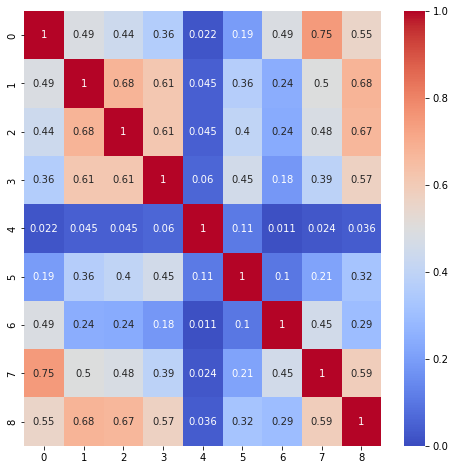

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(simMatrix, vmax=1, vmin=0, annot=True, cmap="coolwarm")

Note that by necessity in this matrix there are values for every combination of rows and columns. This signals that the resulting matrix will be fully connected. Also note that the diagonal is made of 1. This means that every doucument is maximally similar to itself. Note that the matrix is 9x9 and symmetrical (what is above the diagonal is a mirror image of what is below it). This will necessarily result from the comparision process, which will always produce a $ M \times M $ matrix of this sort. 

Such a matrix can be just directly fed into networkx to make a graph.

However it is best to remove the 1s in the diagonal and replace them with 0, as there is no point in stating that every document is linked to itself.


<AxesSubplot:>

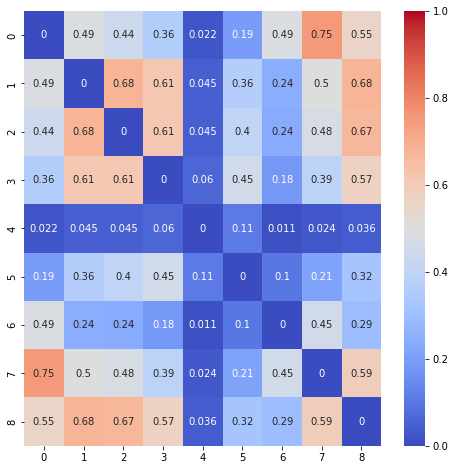

In [8]:
np.fill_diagonal(simMatrix, 0)
plt.figure(figsize=(8,8))
sns.heatmap(simMatrix, vmax=1, vmin=0, annot=True, cmap="coolwarm")

Now we can create the graph and draw the network

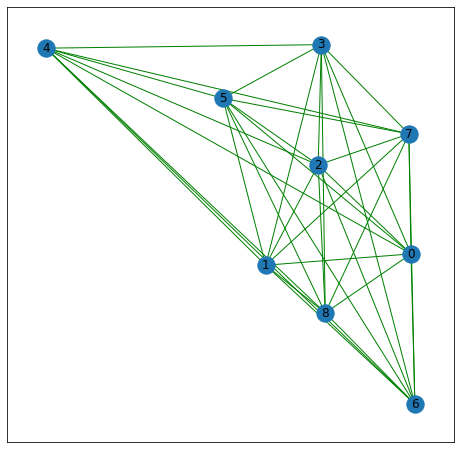

In [11]:
g_docs = nx.from_numpy_matrix(simMatrix)
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_docs, seed=123)
nx.draw_networkx_nodes(g_docs, pos)
lowweight = [e for e in g_docs.edges if g_docs.edges[e]['weight'] < 0.3]
highweight = [e for e in g_docs.edges if g_docs.edges[e]['weight'] > 0.3]
nx.draw_networkx_edges(g_docs, pos = pos, edge_color="green")
# nx.draw_networkx_edges(g_docs, edgelist=highweight, pos=pos, edge_color='green')
# nx.draw_networkx_edges(g_docs, edgelist=lowweight, alpha=0.4, pos=pos, edge_color='red')
nx.draw_networkx_labels(g_docs, pos=pos);

Having such a network, one can venture to find which are the most central reviews, the most prototypical ones using measures that are covered in the main text:

In [12]:
close = nx.closeness_centrality(g_docs, distance="weight")
eig = nx.eigenvector_centrality(g_docs, weight="weight")
pd.DataFrame({"Reviewer":df_reviews.Reviewer, "closeness": list(dict(close).values()), "eig": list(dict(eig).values())})

,Reviewer,closeness,eig
0,Tom,15.777715,0.364633
1,Merrie,12.057838,0.399003
2,Tatler,12.057838,0.394062
3,Nissim,10.367095,0.360242
4,Regina,22.816745,0.036768
5,Nir,7.345767,0.242680
6,David,19.533768,0.233505
7,Richard,15.450462,0.374526
8,Tapas,13.319577,0.409561


Jaccard similarity is possibly the most basic measure of text dsitance, but many others exist, and depending on the measure used it may be wise to pre-process the text before making comparisons, for example removing stopwords. All of this would be beyond the scope of this presentation.